In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
weather_data

,Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,
2021-01-01 00:00:00,0.0,7.2,79.0,9.0
2021-01-01 01:00:00,0.0,7.3,79.0,6.0
2021-01-01 02:00:00,0.0,7.6,78.0,4.0
2021-01-01 03:00:00,0.0,8.2,75.0,4.0
2021-01-01 04:00:00,0.0,7.7,77.0,7.0
...,...,...,...,...
2022-07-31 19:00:00,0.0,26.6,68.0,5.0
2022-07-31 20:00:00,0.0,26.8,65.0,6.0
2022-07-31 21:00:00,0.0,26.7,65.0,5.0


In [4]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [5]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

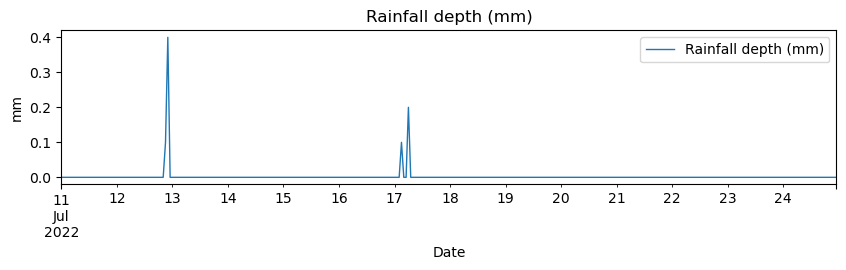

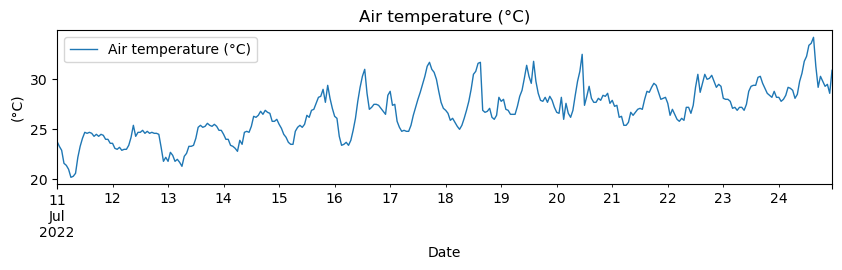

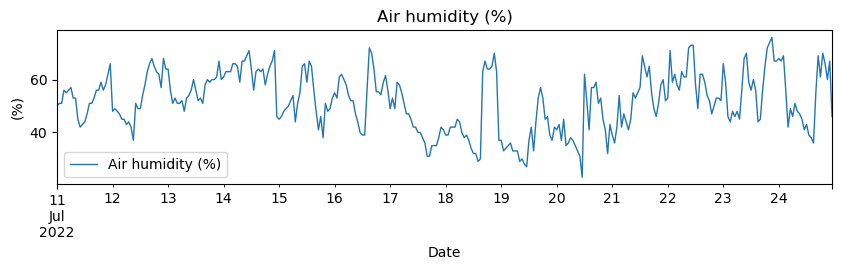

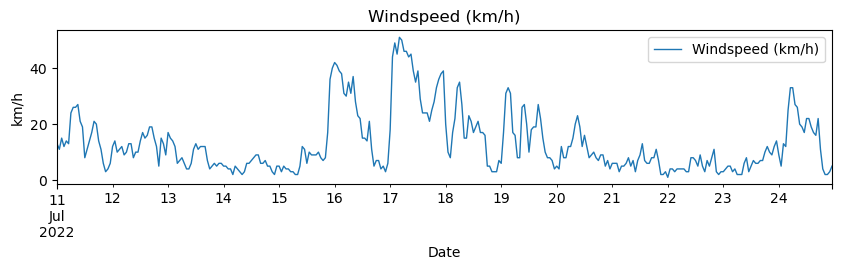

In [6]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-07-11'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

In [7]:
X

,Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h),official_holiday,legally_not_recongnized_holidays,event_day,weekend
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,
2022-07-11 00:00:00,0.0,23.8,50.0,13.0,0,0,0,0
2022-07-11 01:00:00,0.0,23.3,51.0,11.0,0,0,0,0
2022-07-11 02:00:00,0.0,22.9,51.0,15.0,0,0,0,0
2022-07-11 03:00:00,0.0,21.6,56.0,12.0,0,0,0,0
2022-07-11 04:00:00,0.0,21.4,55.0,14.0,0,0,0,0
...,...,...,...,...,...,...,...,...
2022-07-24 19:00:00,0.0,29.8,70.0,4.0,0,0,0,1
2022-07-24 20:00:00,0.0,29.3,66.0,2.0,0,0,0,1
2022-07-24 21:00:00,0.0,29.5,60.0,2.0,0,0,0,1


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82175D+00    |proj g|=  2.63632D-01


 This problem is unconstrained.



At iterate    5    f=  1.75375D+00    |proj g|=  8.82825D-02

At iterate   10    f=  1.73981D+00    |proj g|=  2.39822D-02

At iterate   15    f=  1.73806D+00    |proj g|=  6.44570D-02

At iterate   20    f=  1.73595D+00    |proj g|=  5.76279D-02

At iterate   25    f=  1.73281D+00    |proj g|=  4.54467D-02

At iterate   30    f=  1.71515D+00    |proj g|=  6.63417D-02

At iterate   35    f=  1.71127D+00    |proj g|=  2.20801D-02

At iterate   40    f=  1.70986D+00    |proj g|=  6.78325D-03

At iterate   45    f=  1.70859D+00    |proj g|=  5.14012D-02

At iterate   50    f=  1.70637D+00    |proj g|=  4.68312D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

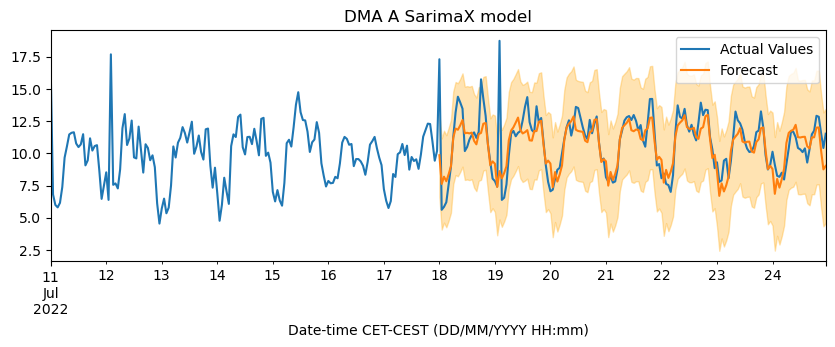

Performance indicators
DMA A SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.40            7.45             0.83           9.68 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.74            7.56             1.98           12.28 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10557D-01    |proj g|=  3.72799D-01


 This problem is unconstrained.



At iterate    5    f=  8.70801D-01    |proj g|=  4.83028D-01

At iterate   10    f=  8.54633D-01    |proj g|=  1.37637D-01

At iterate   15    f=  8.46325D-01    |proj g|=  6.58391D-02

At iterate   20    f=  8.36004D-01    |proj g|=  4.39037D-01

At iterate   25    f=  8.32118D-01    |proj g|=  1.72453D-01

At iterate   30    f=  8.00090D-01    |proj g|=  2.00597D-01

At iterate   35    f=  7.69569D-01    |proj g|=  1.72104D-01

At iterate   40    f=  7.65285D-01    |proj g|=  1.01996D-01

At iterate   45    f=  7.64495D-01    |proj g|=  7.72159D-02

At iterate   50    f=  7.63950D-01    |proj g|=  1.00784D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

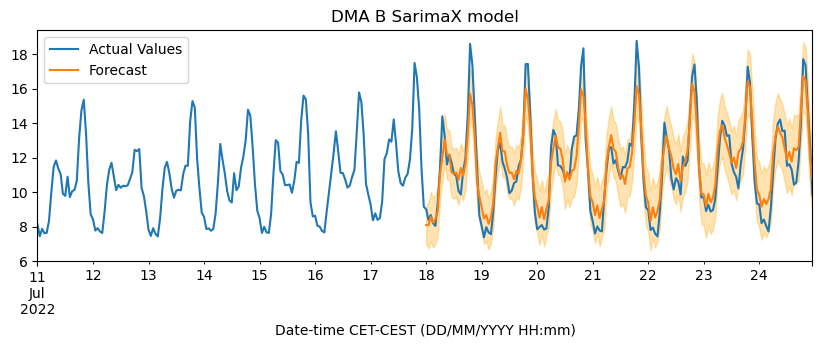

Performance indicators
DMA B SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.79            2.88             0.78           4.46 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.16            7.90             2.17           12.22 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82716D-01    |proj g|=  6.00102D-01


 This problem is unconstrained.



At iterate    5    f=  7.45521D-01    |proj g|=  1.34359D-01

At iterate   10    f=  7.11770D-01    |proj g|=  1.13903D-01

At iterate   15    f=  7.01618D-01    |proj g|=  1.45847D-01

At iterate   20    f=  6.96510D-01    |proj g|=  9.55565D-02

At iterate   25    f=  6.91868D-01    |proj g|=  1.42066D-01

At iterate   30    f=  6.87014D-01    |proj g|=  9.64951D-02

At iterate   35    f=  6.81728D-01    |proj g|=  1.36576D-01

At iterate   40    f=  6.79552D-01    |proj g|=  4.02674D-02

At iterate   45    f=  6.78611D-01    |proj g|=  3.00848D-02

At iterate   50    f=  6.78386D-01    |proj g|=  3.74420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

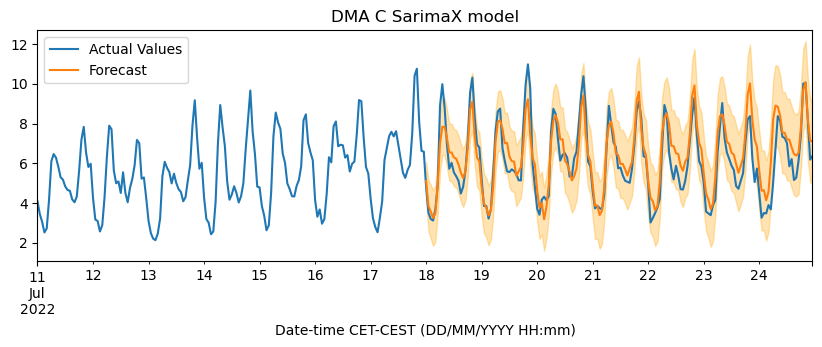

Performance indicators
DMA C SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.70            2.15             0.71           3.56 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.74            4.83             1.50           8.07 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52244D+01    |proj g|=  7.33749D+01


 This problem is unconstrained.



At iterate    5    f=  2.40516D+00    |proj g|=  2.89353D-01

At iterate   10    f=  2.29191D+00    |proj g|=  1.05304D-01

At iterate   15    f=  2.23201D+00    |proj g|=  1.10408D-01

At iterate   20    f=  2.20950D+00    |proj g|=  1.75188D-02

At iterate   25    f=  2.20361D+00    |proj g|=  6.97471D-02

At iterate   30    f=  2.19849D+00    |proj g|=  3.28616D-02

At iterate   35    f=  2.19005D+00    |proj g|=  9.33602D-03

At iterate   40    f=  2.18986D+00    |proj g|=  5.56456D-03

At iterate   45    f=  2.18735D+00    |proj g|=  1.28860D-01

At iterate   50    f=  2.18359D+00    |proj g|=  1.35708D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

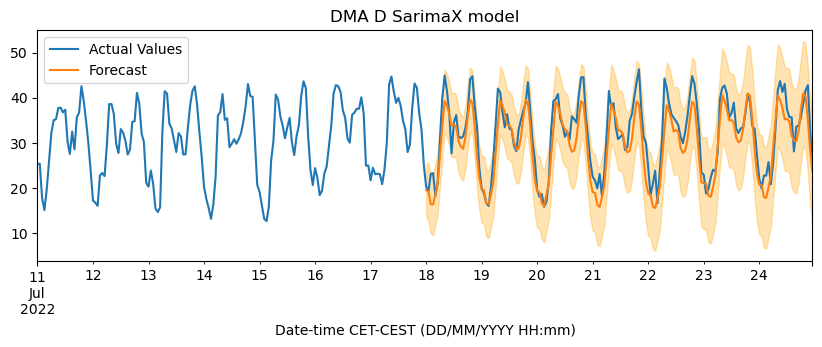

Performance indicators
DMA D SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.15            6.99             3.09           13.23 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.97            14.29             6.85           28.11 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29870D+00    |proj g|=  9.64977D-01


 This problem is unconstrained.



At iterate    5    f=  1.85378D+00    |proj g|=  1.44789D-01

At iterate   10    f=  1.79740D+00    |proj g|=  8.97024D-02

At iterate   15    f=  1.79010D+00    |proj g|=  2.57645D-02

At iterate   20    f=  1.78673D+00    |proj g|=  1.26243D-02

At iterate   25    f=  1.78230D+00    |proj g|=  7.26709D-02

At iterate   30    f=  1.77623D+00    |proj g|=  4.12059D-02

At iterate   35    f=  1.76609D+00    |proj g|=  5.31734D-02

At iterate   40    f=  1.76327D+00    |proj g|=  1.97120D-02

At iterate   45    f=  1.76306D+00    |proj g|=  9.83218D-03

At iterate   50    f=  1.76285D+00    |proj g|=  1.71381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

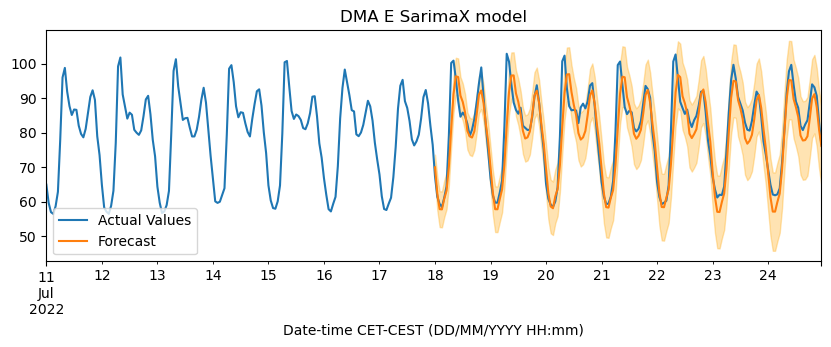

Performance indicators
DMA E SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.74            19.13             3.64           26.51 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.98            21.78             10.71           43.47 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98825D+00    |proj g|=  9.94708D-01


 This problem is unconstrained.



At iterate    5    f=  1.62714D+00    |proj g|=  1.27736D-01

At iterate   10    f=  1.46826D+00    |proj g|=  1.39201D-01

At iterate   15    f=  1.46170D+00    |proj g|=  6.86286D-02

At iterate   20    f=  1.41925D+00    |proj g|=  2.65130D-01

At iterate   25    f=  1.41185D+00    |proj g|=  3.78671D-02

At iterate   30    f=  1.41026D+00    |proj g|=  4.20696D-03

At iterate   35    f=  1.41022D+00    |proj g|=  6.59167D-03

At iterate   40    f=  1.41014D+00    |proj g|=  2.70400D-02

At iterate   45    f=  1.40963D+00    |proj g|=  1.92877D-02

At iterate   50    f=  1.40826D+00    |proj g|=  5.53880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

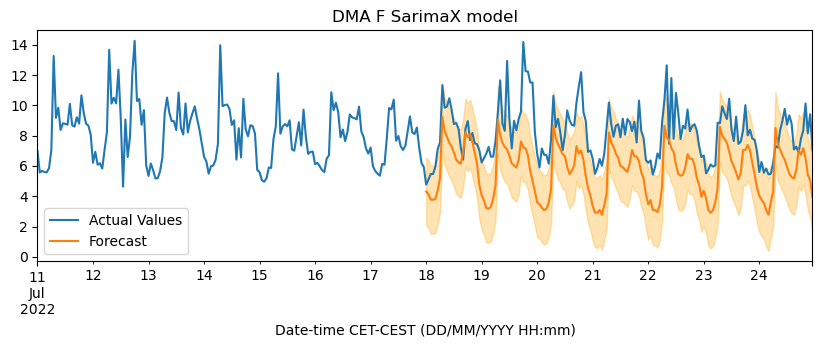

Performance indicators
DMA F SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.57            2.93             2.67           7.16 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.43            3.30             1.38           6.10 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45519D+00    |proj g|=  2.34115D-01


 This problem is unconstrained.



At iterate    5    f=  1.43937D+00    |proj g|=  5.59231D-02

At iterate   10    f=  1.43818D+00    |proj g|=  2.36169D-02

At iterate   15    f=  1.43708D+00    |proj g|=  2.66793D-02

At iterate   20    f=  1.43666D+00    |proj g|=  7.29294D-03

At iterate   25    f=  1.43529D+00    |proj g|=  3.00654D-02

At iterate   30    f=  1.43449D+00    |proj g|=  1.68127D-02

At iterate   35    f=  1.43380D+00    |proj g|=  3.89494D-02

At iterate   40    f=  1.43048D+00    |proj g|=  3.84011D-02

At iterate   45    f=  1.42688D+00    |proj g|=  2.78246D-02

At iterate   50    f=  1.42602D+00    |proj g|=  2.11070D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

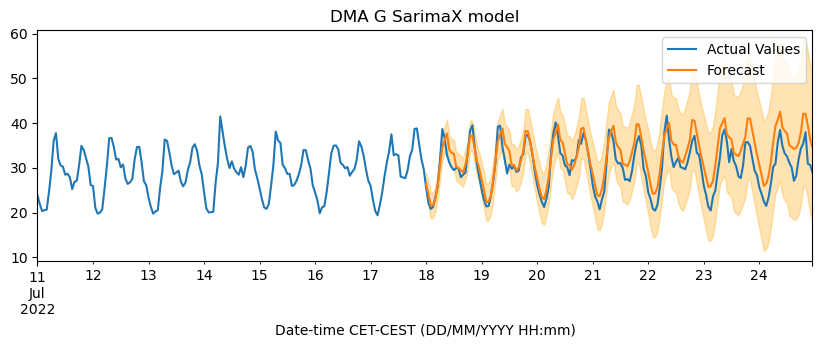

Performance indicators
DMA G SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.54            4.83             3.08           9.46 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.12            10.48             4.38           18.97 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74329D+00    |proj g|=  3.42426D-01


 This problem is unconstrained.



At iterate    5    f=  1.62069D+00    |proj g|=  1.52794D-01

At iterate   10    f=  1.60777D+00    |proj g|=  1.21460D-01

At iterate   15    f=  1.60535D+00    |proj g|=  3.46140D-02

At iterate   20    f=  1.60470D+00    |proj g|=  2.98180D-02

At iterate   25    f=  1.60284D+00    |proj g|=  4.50831D-02

At iterate   30    f=  1.59366D+00    |proj g|=  2.53738D-02

At iterate   35    f=  1.59259D+00    |proj g|=  2.02785D-02

At iterate   40    f=  1.59198D+00    |proj g|=  1.47148D-02

At iterate   45    f=  1.59193D+00    |proj g|=  4.23688D-03

At iterate   50    f=  1.59109D+00    |proj g|=  2.85872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

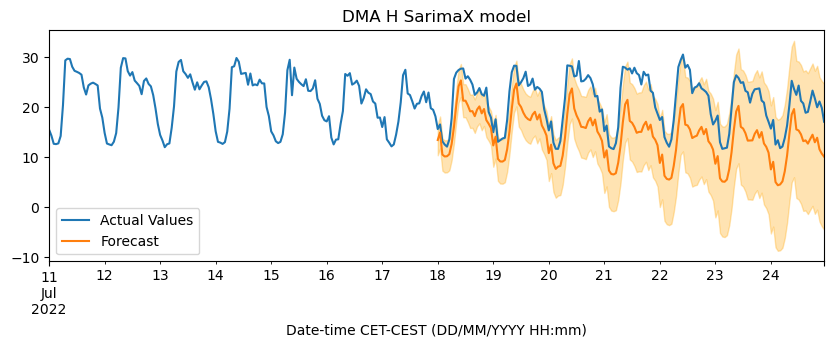

Performance indicators
DMA H SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.06            9.62             7.41           21.09 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.53            9.23             4.50           18.27 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60243D+00    |proj g|=  5.12630D-01


 This problem is unconstrained.



At iterate    5    f=  1.54989D+00    |proj g|=  5.31408D-02

At iterate   10    f=  1.54561D+00    |proj g|=  3.04336D-02

At iterate   15    f=  1.54140D+00    |proj g|=  3.32690D-02

At iterate   20    f=  1.53813D+00    |proj g|=  1.68514D-02

At iterate   25    f=  1.53766D+00    |proj g|=  3.35866D-02

At iterate   30    f=  1.53754D+00    |proj g|=  2.19341D-03

At iterate   35    f=  1.53749D+00    |proj g|=  5.23604D-03

At iterate   40    f=  1.53732D+00    |proj g|=  2.15617D-03

At iterate   45    f=  1.53729D+00    |proj g|=  3.55521D-03

At iterate   50    f=  1.53727D+00    |proj g|=  2.21902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

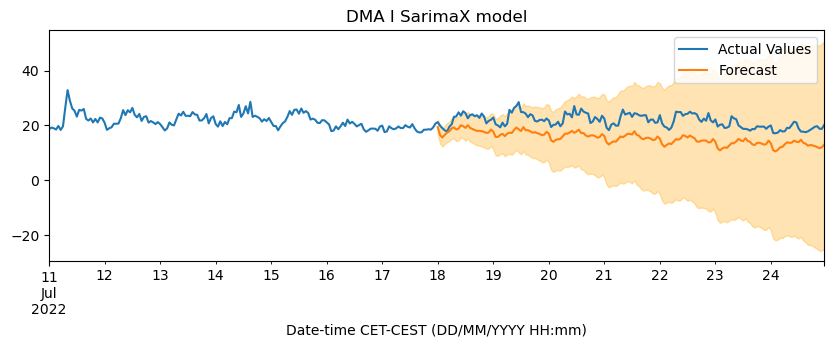

Performance indicators
DMA I SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.93            6.43             6.56           16.92 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.92            3.93             2.14           8.00 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68798D+00    |proj g|=  1.91882D-01


 This problem is unconstrained.



At iterate    5    f=  1.65592D+00    |proj g|=  1.83734D-01

At iterate   10    f=  1.64996D+00    |proj g|=  7.46128D-03

At iterate   15    f=  1.64758D+00    |proj g|=  2.79346D-02

At iterate   20    f=  1.64637D+00    |proj g|=  6.38553D-03

At iterate   25    f=  1.64626D+00    |proj g|=  4.98594D-03

At iterate   30    f=  1.64624D+00    |proj g|=  4.31549D-03

At iterate   35    f=  1.64621D+00    |proj g|=  3.33591D-03

At iterate   40    f=  1.64618D+00    |proj g|=  3.84359D-03

At iterate   45    f=  1.64615D+00    |proj g|=  2.90509D-03

At iterate   50    f=  1.64612D+00    |proj g|=  1.12410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

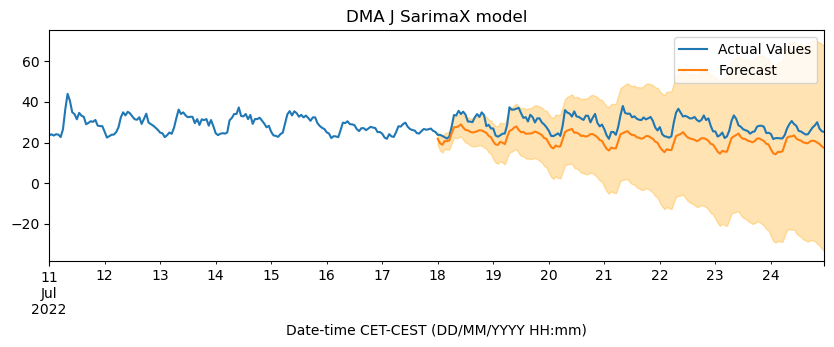

Performance indicators
DMA J SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.21            8.88             7.55           21.64 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.11            6.84             3.71           14.65 



In [8]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(4,1,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 1-Week',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [9]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 1-Week,1.398,7.452,0.830,9.681
DMA B SarimaX 1-Week,0.791,2.883,0.784,4.458
DMA C SarimaX 1-Week,0.702,2.145,0.708,3.556
DMA D SarimaX 1-Week,3.148,6.995,3.091,13.233
DMA E SarimaX 1-Week,3.740,19.130,3.636,26.506
DMA F SarimaX 1-Week,1.567,2.929,2.668,7.165
DMA G SarimaX 1-Week,1.544,4.835,3.084,9.462
DMA H SarimaX 1-Week,4.062,9.618,7.409,21.089
DMA I SarimaX 1-Week,3.925,6.435,6.562,16.922
DMA J SarimaX 1-Week,5.213,8.878,7.547,21.637


In [10]:
print(f"{results_df['Total'].sum() :.2f}")

133.71


In [11]:
print(f"{results_df.drop('DMA E SarimaX 1-Week')['Total'].sum() :.2f}")

107.20
